# K-means clustering

Author: Chris Nunn, Jeremy Rothschild

[Theory](#linkTheory)  <br>
[Example 1: Data that lends itself to K-means](#linkExample1)  <br>
[Example 2: Where K-means fails](#linkExample2) <br>
[Connection to EM and GMMs](#linkEMGMM) <br>

 
[Resources](#linkResources)  

### Theory<a id='linkTheory'></a>

Given a set of $d$-dimensional observations $(\textbf{x}_1,\textbf{x}_1,..,\textbf{x}_n)$, we would like to partition the data into $k<n$ clusters. We can assign a $d$-dimensional vector $\mu_k$ to each cluster and ask what sort of assignment of data points to these clusters minimizes the sum of the square distances of each data point to the closest $\mu_k$. This is the aim of $k$-means.

\begin{equation}
\underset{S}{\arg\min}\sum^k_{j=1}\sum_{x_i\in S_j} \| \textbf{x}-\mu_j \|^2
\end{equation}

We can look at this problem from the perspective of minimizing an objective function $J$. This objective function is

\begin{equation}
J = \sum^n_{i=1}\sum^k_{j=1} r_{ij} \| \textbf{x}_i-\mu_j \|^2
\end{equation}

such that

\begin{equation}
r_{ij} = \begin{cases}
    1 \quad &\text{if} \, x_i \in S_j \\
    0  &\text{otherwise.}
         \end{cases}
\end{equation}

Theis is a NP-hard problem, however there is an efficient algorithm employed that converges quickly to local optimum, similar to the expectation-maximization algorithm (which we'll discuss in the future).

#### k-means algorithm

1. Initialize the $\mu_j^{old}$.
2. **E**valuate the $r_{ij}$ given these $\mu_j^{old}$.
3. Optimize (**M**inimize) J with respect to $\mu_j$ given these $r_{ij}$

\begin{equation}
0 = \frac{\partial J}{\partial \mu_j} = -2\sum^n_{i=1}r_{ij} (x_i - \mu_j)
\end{equation}
    solving for $\mu_j$
\begin{equation}
\mu_j = \frac{\sum^n_{i=1}r_{ij}x_i}{\sum^n_{i=1}r_{ij}}
\end{equation}
    this is $\mu_j^{new}$
4. Check that $\mu_j^{new}==\mu_j^{old}$. If not set $\mu_j^{new}\rightarrow \mu_j^{old}$ and go back to step 2. Otherwise, terminate

*Note* it is possible to initialize the $r_{ij}$ first.

#### Discussion

We used the Euclidian metric to define the distance between points, but this isn't necessary. We could use some other metric $\phi$ and similarily minimize

\begin{equation}
J = \sum^n_{i=1}\sum^k_{j=1} r_{ij} \phi (x_i,\mu_j)
\end{equation}

#### Code

In the following sections we *(Chris using the Royal We, Jeremy did absolutely nothing here)* have written our own K-means implementation to make these algorithmic steps as clear as possible. 


### Example 1: Nice clumpy data<a id='linkExample1'></a>

In [774]:
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.datasets.samples_generator import make_blobs
from sklearn.datasets import make_moons
from sklearn.datasets import make_circles

Generate some data with a number of fuzzy clusters, then plot it.


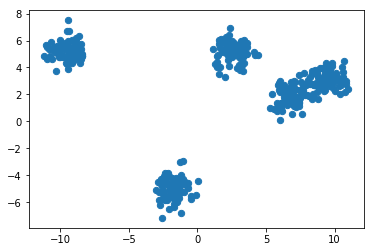

In [796]:
x,x_label = make_blobs(n_samples=400, centers=5, cluster_std=0.70, random_state=None)
plt.scatter(x[:,0], x[:,1], s=40)

Below is a verbose, naive implementation of k-means for teaching purposes:

In [746]:
class kmeans:
    
    #define a clustered object by providing input data (x), and the number 
    #of clustered centers
    def __init__(self, x, k, iterate):
        self.iter = iterate
        self.x = x
        self.k = k
        self.mu = [] #list of current cluster centroids
        self.mu_prev = [] #list of previous cluster centroids
        self.clusters= [[] for _ in xrange(k)] #list of current clusters
        self.all_clusters = [] #list of iterations of clusters
        self.all_centroid_seeds = [] #list of centroid starting positions
        self.all_centroid_term = [] #list of locations where centroids end

    #assign objects to clusters based on shortest Euclidean distance
    def assign_clusters(self):
        self.clusters= [[] for _ in xrange(self.k)]
        
        for obj in self.x:
            distances = []
            for cent in self.mu:
                distances.append(np.linalg.norm(np.subtract(obj,cent)))
            min_index = np.argmin(distances)
            self.clusters[min_index].append(list(obj))
            
    #adjust centroids based on most recent cluster assignment
    def adjust_centers(self):
        newmu = []
        for i in xrange(len(self.clusters)):
            newmu.append(np.mean(self.clusters[i], axis=0).tolist())
        self.mu=newmu
        
    #detect when centers remain unchanged after some iterations
    def centers_equal(self):
        return  (set([tuple(pt) for pt in self.mu_prev]) == set([tuple(t) for t in self.mu]))
    
    #get access to cluster assignment
    def get_clusters(self):
        return self.clusters
    
    def get_starting_centroids(self):
        return self.start_centroids
    
    def get_final_centroids(self):
        return self.final_centroids
    
    #run MAIN
    def perform_kmeans(self):
        for i in xrange(self.iter):
            #set random seeds for CM locations
            self.mu_prev = random.sample(self.x, self.k)
            self.mu = random.sample(self.x, self.k)
            
            #save the initial CM seed
            self.all_centroid_seeds.append(self.mu)
            print "iteration " + str(i) + ": \n"
            counter = 0
            while not self.centers_equal():
                counter+=1
                self.mu_prev = self.mu
                self.assign_clusters()
                self.adjust_centers()
            print "converged to local minima in " + str(counter) + " steps \n"
            self.all_clusters.append(self.clusters)
            #save final centroid position
            self.all_centroid_term.append(self.mu)
            
        #choose iteration to plot by minimizing within cluster variance
        var_list = []
        for i in xrange(len(self.all_clusters)):
            var_sum = 0
            for j in xrange(len(self.all_clusters[i])):
                var_sum +=len(self.all_clusters[i][j])*np.var(self.all_clusters[i][j])
            var_list.append(var_sum)
        self.clusters = self.all_clusters[np.argmin(var_list)]
        self.final_centroids = self.all_centroid_term[np.argmin(var_list)]
        self.start_centroids = self.all_centroid_seeds[np.argmin(var_list)]
          

We can run this with the following:

iteration 0: 

converged to local minima in 8 steps 

iteration 1: 

converged to local minima in 5 steps 

iteration 2: 

converged to local minima in 5 steps 

iteration 3: 

converged to local minima in 5 steps 

iteration 4: 

converged to local minima in 9 steps 

iteration 5: 

converged to local minima in 8 steps 

iteration 6: 

converged to local minima in 5 steps 

iteration 7: 

converged to local minima in 10 steps 

iteration 8: 

converged to local minima in 6 steps 

iteration 9: 

converged to local minima in 6 steps 



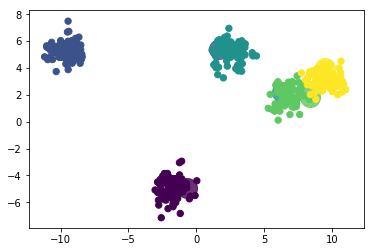

In [797]:
cluster_obj = kmeans(x, 5, 10) #(data, number of clusters, number of iterations)
cluster_obj.perform_kmeans()
clusters =  cluster_obj.get_clusters() #these are the 'best' clusters
finalcentroids = cluster_obj.get_final_centroids()
startingcentroids = cluster_obj.get_starting_centroids()

#plot each cluster, with final centroid location
for i in range(len(clusters)):
    series_colours = [i] *len(clusters[i])
    plt.scatter(*zip(*clusters[i]), c=series_colours, cmap='viridis', s=40, vmin=0, vmax=len(clusters)-1)
    plt.scatter(startingcentroids[i][0], startingcentroids[i][1], c=i, cmap='viridis', s=400, alpha=0.8, vmin=0, vmax=len(clusters)-1)


### Example 2: Nonlinear boundaries (curves/nested circles) <a id='linkExample2'></a>

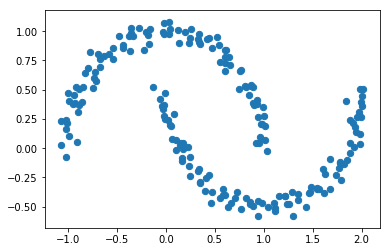

In [798]:
y,y_label = make_moons(200, noise=.05, random_state=0)
plt.scatter(y[:,0], y[:,1], s=40)

iteration 0: 

converged to local minima in 8 steps 



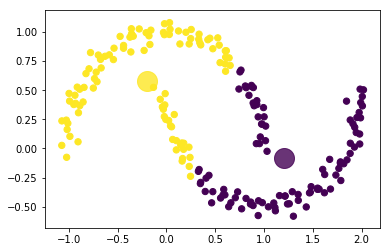

In [799]:
cluster_obj = kmeans(y, 2, 1) #(data, number of clusters, number of iterations)
cluster_obj.perform_kmeans()
clusters =  cluster_obj.get_clusters() #these are the 'best' clusters
finalcentroids = cluster_obj.get_final_centroids()
startingcentroids = cluster_obj.get_starting_centroids()

#plot each cluster, with final centroid location
for i in range(len(clusters)):
    series_colours = [i] *len(clusters[i])
    plt.scatter(*zip(*clusters[i]), c=series_colours, cmap='viridis', s=40, vmin=0, vmax=len(clusters)-1)
    plt.scatter(finalcentroids[i][0], finalcentroids[i][1], c=i, cmap='viridis', s=400, alpha=0.8, vmin=0, vmax=len(clusters)-1)

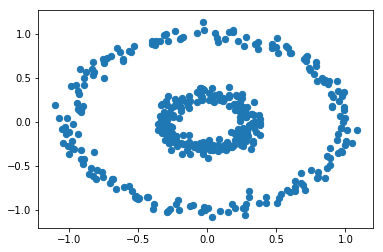

In [787]:
z, z_labels = make_circles(n_samples=400, factor=.3, noise=.05)
plt.scatter(z[:,0], z[:,1], s=40)

iteration 0: 

converged to local minima in 12 steps 



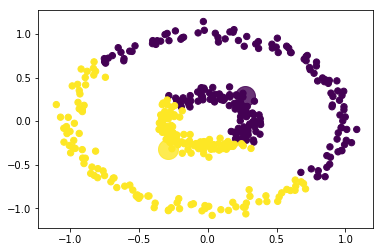

In [800]:
cluster_obj = kmeans(z, 2, 1) #(data, number of clusters, number of iterations)
cluster_obj.perform_kmeans()
clusters =  cluster_obj.get_clusters() #these are the 'best' clusters
finalcentroids = cluster_obj.get_final_centroids()
startingcentroids = cluster_obj.get_starting_centroids()

#plot each cluster, with final centroid location
for i in range(len(clusters)):
    series_colours = [i] *len(clusters[i])
    plt.scatter(*zip(*clusters[i]), c=series_colours, cmap='viridis', s=40, vmin=0, vmax=len(clusters)-1)
    plt.scatter(finalcentroids[i][0], finalcentroids[i][1], c=i, cmap='viridis', s=400, alpha=0.8, vmin=0, vmax=len(clusters)-1)

### K-means as a special case of EM <a id='linkEMGMM'></a>